# Gradient Computation, Update and Normalize

The computation is the following:
$$\frac{\partial C}{\partial \mathcal{Y}} = \sum_j (p_{ij} - \frac{t_{ij}}{T})t_{ij} (y_i - y_j)$$
$$\mathcal{Y}^{(t)} - \mathcal{Y}^{(t-1)} = \eta (\mathcal{Y}^{(t-1)} - \mathcal{Y}^{(t-2)}) - \alpha \frac{\partial C}{\partial \mathcal{Y}}$$

This function have the following cost:
* adds: $N^2 (1+4) + 4 N + 2 N$
* mults: $N^2 4 + 2$
* total: $9 N^2 + 4 N + 2$

So:
$$W =9 N^2 + 4 N + 2\quad flops$$

The memory traffic is:
$$Q = 4(2 N^2 + 2 N d)$$

And so the operational intensity is for low dimensions ($d=2$):
$$I = \frac{9 N^2 + 4 N + 2}{8 N^2 + 16 N} \approxeq \frac{9}{8} ~ \text{flops/byte}$$
The computation will be **memory bound**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from visualization import plot

mpl.rcParams['figure.figsize'] = (8.1, 5)
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['font.family'] = 'Roboto'
mpl.rcParams['font.size'] = 15

Cache sizes and limits taking into account that the working set is:
$$W_{set} = 2 N^2 + 2 N d$$

In [2]:
cache_1 = 32 * 2**10    # 32 KB
cache_2 = 256 * 2**10   # 256 KB
cache_3 = 8 * 2**20.    # 8 MB


N_cache1 = np.sqrt(cache_1 / 4 / 2 + 1) - 1
N_cache2 = np.sqrt(cache_2 / 4 / 2 + 1) - 1
N_cache3 = np.sqrt(cache_3 / 4 / 2 + 1) - 1
print(f"Cache 1 limit size: {N_cache1:.0f}")
print(f"Cache 2 limit size: {N_cache2:.0f}")
print(f"Cache 3 limit size: {N_cache3:.0f}")

Cache 1 limit size: 63
Cache 2 limit size: 180
Cache 3 limit size: 1023


# Euler

### System Information

Compiler:
```
icc 16.0.0
```

CPU: **Intel Xeon E3-1285Lv5 Skylake 3.00 GHz**

Cache:
* L1: 32 KB
* L2: 256 KB
* L3: 8 MB

Memory bandwidth: 34.1 GB/s (theoretical)

## Benchmark 1

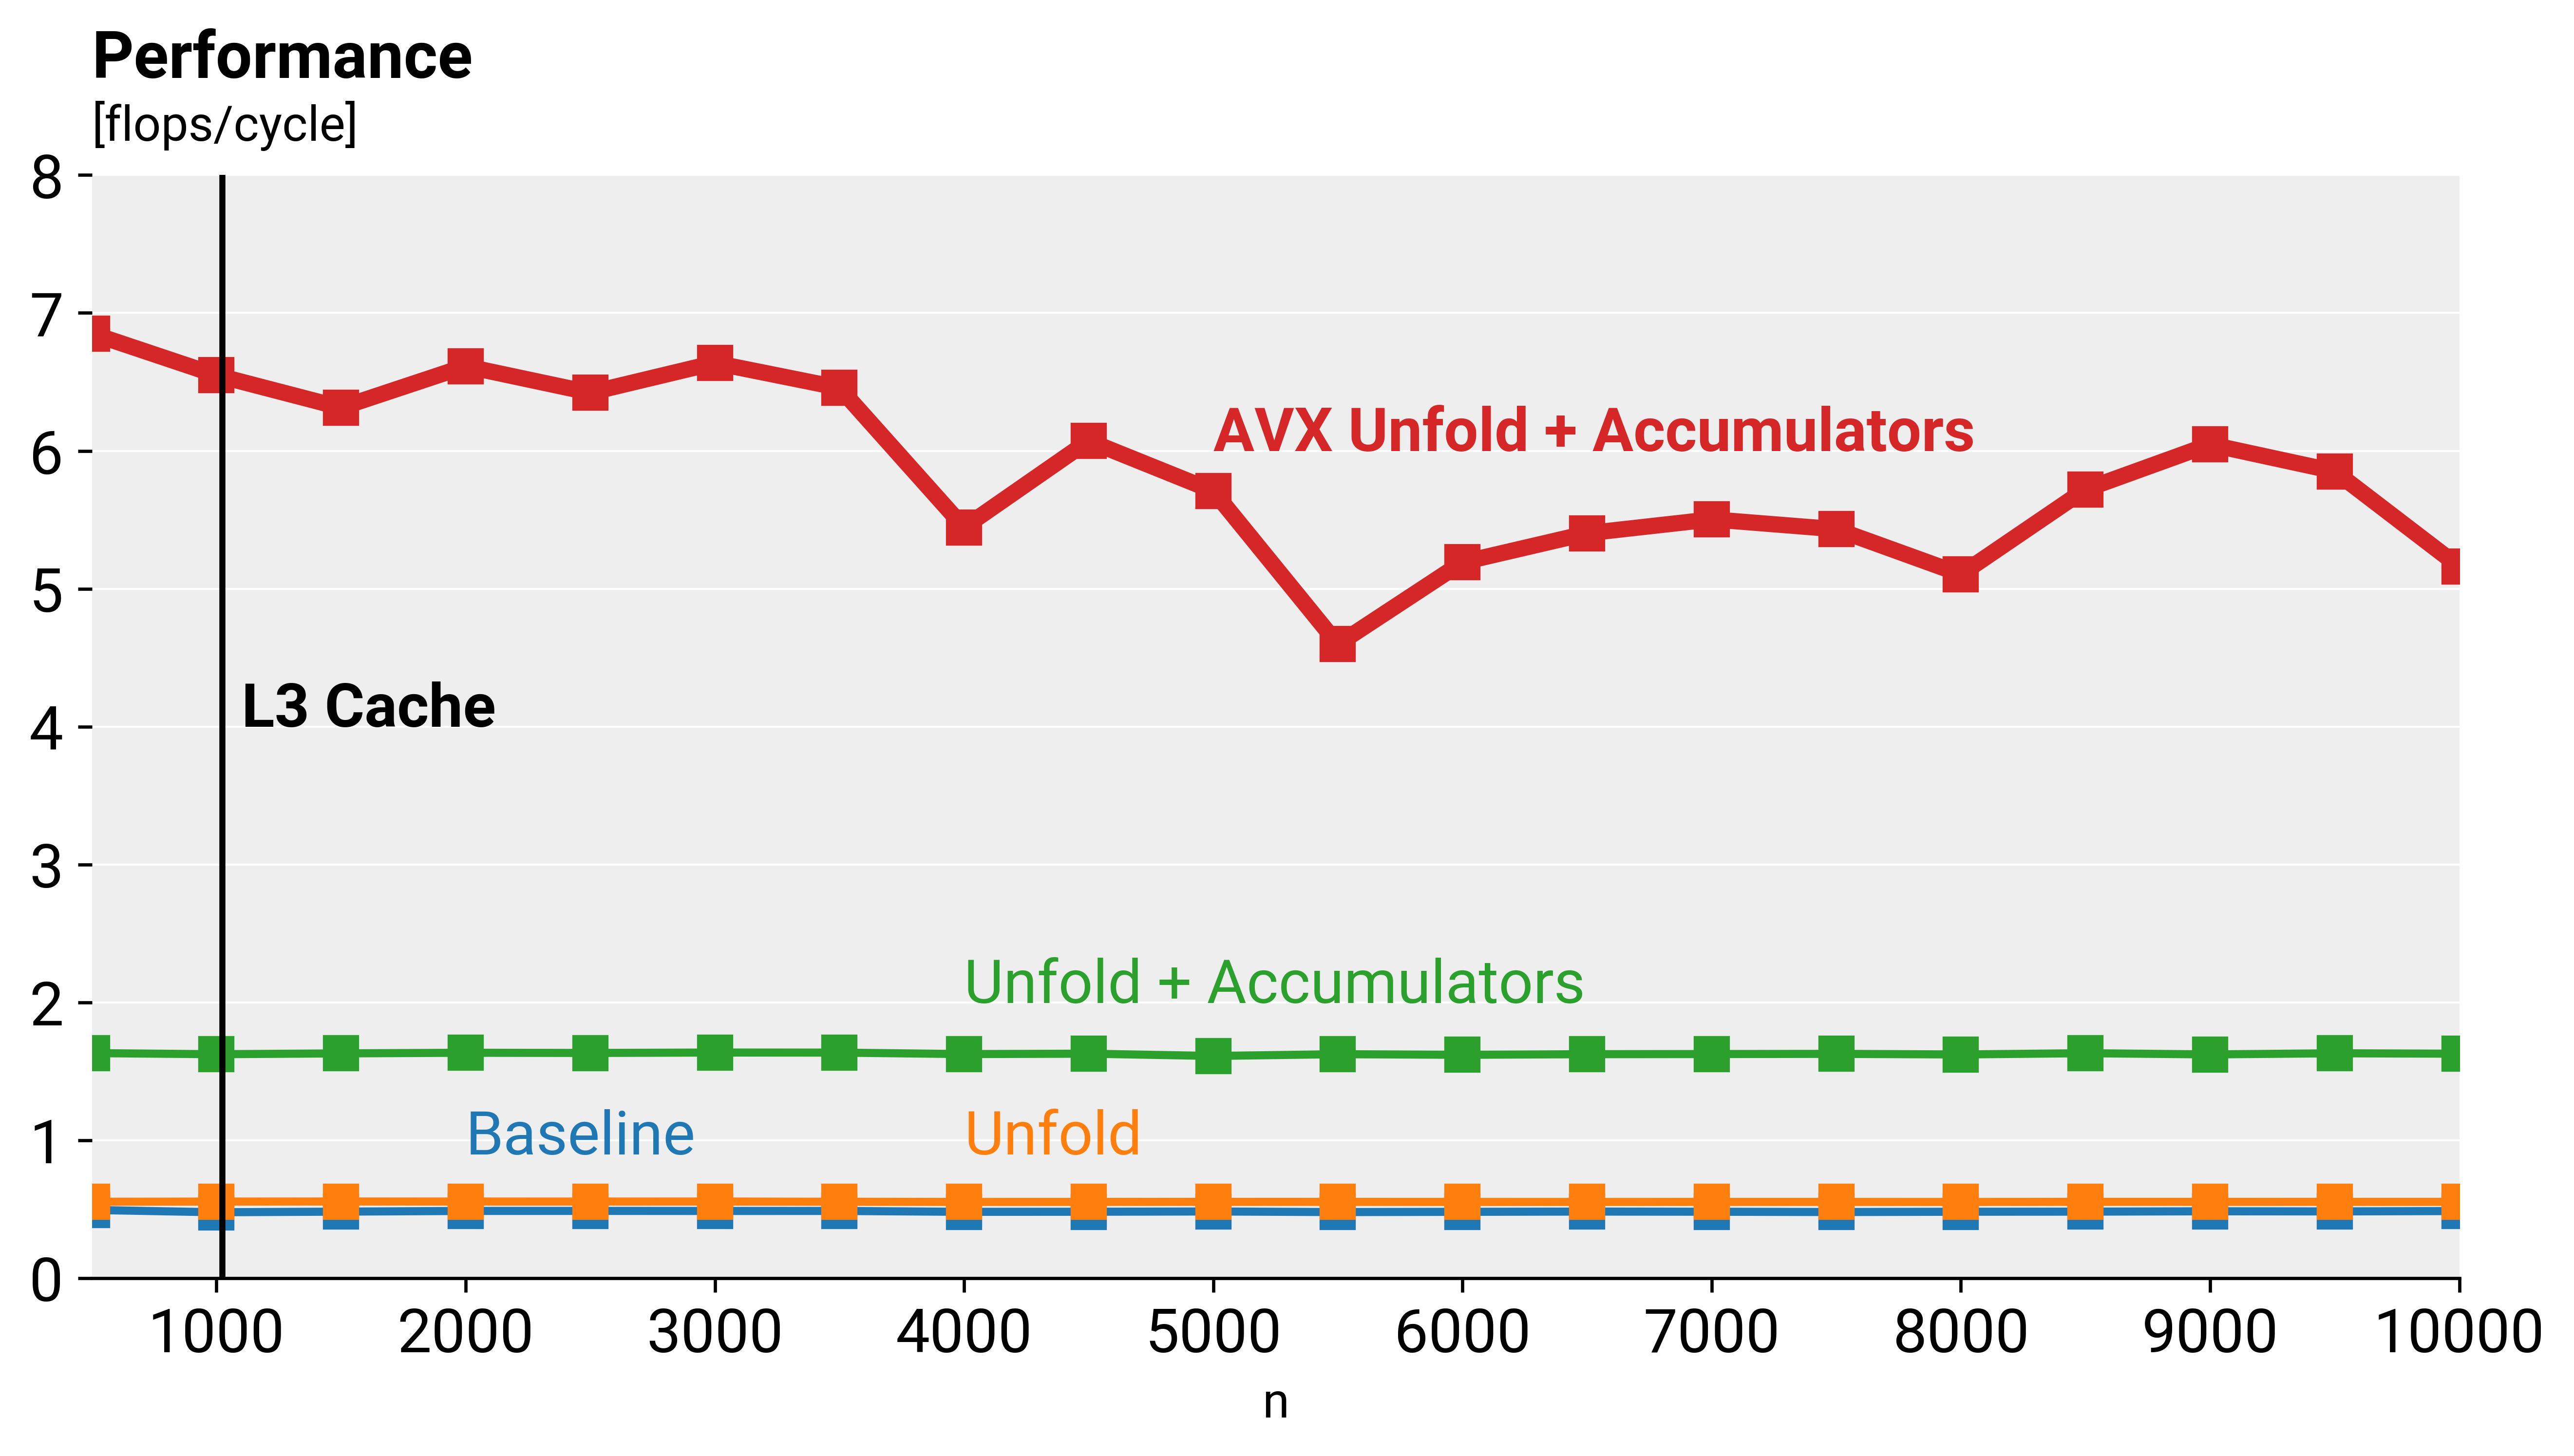

In [15]:
data = pd.read_csv("./euler/bench.csv")
# Extract the input size
N = data["N"].as_matrix()
# Decompose the data frame into the different functions and compute the performance
func_names = data.columns.values[1:]
perf = []
flops = {
    "base_version": 9 * N * (N - 1) + 4*N + 2,
    "fused": 9 * N**2 + 4*N + 2,
    "unfold_accumulators": 9 * N**2 + 4*N + 2,
    "unfold_accumulators_avx": N/16*(N/8*(16*8 + 4*8*8 + 4*4*8 + 4*4*8 + 4*16*8) + (4*8 + 4*16)) +
        N/(4*8) * (8*8) + 11*8 + N/(4*8)*(8*8),
}

for func in func_names:
    cycles = data[func].as_matrix()
    P = flops[func] / cycles
    perf.append(P)
perf = np.array(perf)

title = "Performance"
ylabel = "flops/cycle"
legend = False
lw = 2
marker = "s"
markersize = 8
labels_fontsize = 12
fontsize = 20
xlabel = "n"
ylim = 8

fig = plt.figure()
if title:
    fig.suptitle(title, fontweight='bold', fontsize=16, x=0, ha='left')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=.88, left=0, right=1)

base, = ax.plot(N, perf[0], linewidth=lw, marker=marker, markersize=markersize, label="Baseline")
unfold, =ax.plot(N, perf[1], linewidth=lw, marker=marker, markersize=markersize, label="Unfold")
unfold2, = ax.plot(N, perf[2], linewidth=lw, marker=marker, markersize=markersize, label="Unfold + Accumulators")
avx, = ax.plot(N, perf[3], linewidth=2*lw, marker=marker, markersize=markersize, label="AVX Unfold + Accumulators")

ax.text(2000, 0.9, "Baseline", color=base.get_color())
ax.text(4000, 0.9, "Unfold", color=unfold.get_color())

ax.text(4000, 2, "Unfold + Accumulators", color=unfold2.get_color())
ax.text(5000, 6, "AVX Unfold + Accumulators", color=avx.get_color(), fontweight="bold")

if legend:
    ax.legend()
ax.set_ylim([0, ylim])

ax.set_xlim([N.min(), N.max()])
ax.set_xlabel(xlabel, fontsize=labels_fontsize)

# For runtime plots where on the yaxis there is an exponent, place the text
# on the axis title
exponent_text = ''
ax.ticklabel_format(axis='y', style='sci')
plt.draw()
if ax.yaxis.get_offset_text().get_text() != '':
    ax.yaxis.major.formatter._useMathText = True
    plt.draw()
    exponent_text = '[{}]'.format(ax.yaxis.get_offset_text().get_text())
    ax.yaxis.offsetText.set_visible(False)

ax.set_title(
    '[{}]{}'.format(ylabel, exponent_text),
    fontsize=labels_fontsize,
    position=(0, 1.0),
    ha='left',
    va='bottom')

ax.yaxis.grid(color='#ffffff', linestyle='-', linewidth=.5)
ax.set_facecolor('#eeeeee')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.set_xticks(np.arange(1000, 10000+1, 1000))
ax.set_xticklabels(np.arange(1000, 10000+1, 1000))
ax.axvline(N_cache3, c="k")
ax.text(1100, 4, "L3 Cache", fontweight="bold")

plt.savefig("euler/bench.png", bbox_inches="tight")

plt.show()

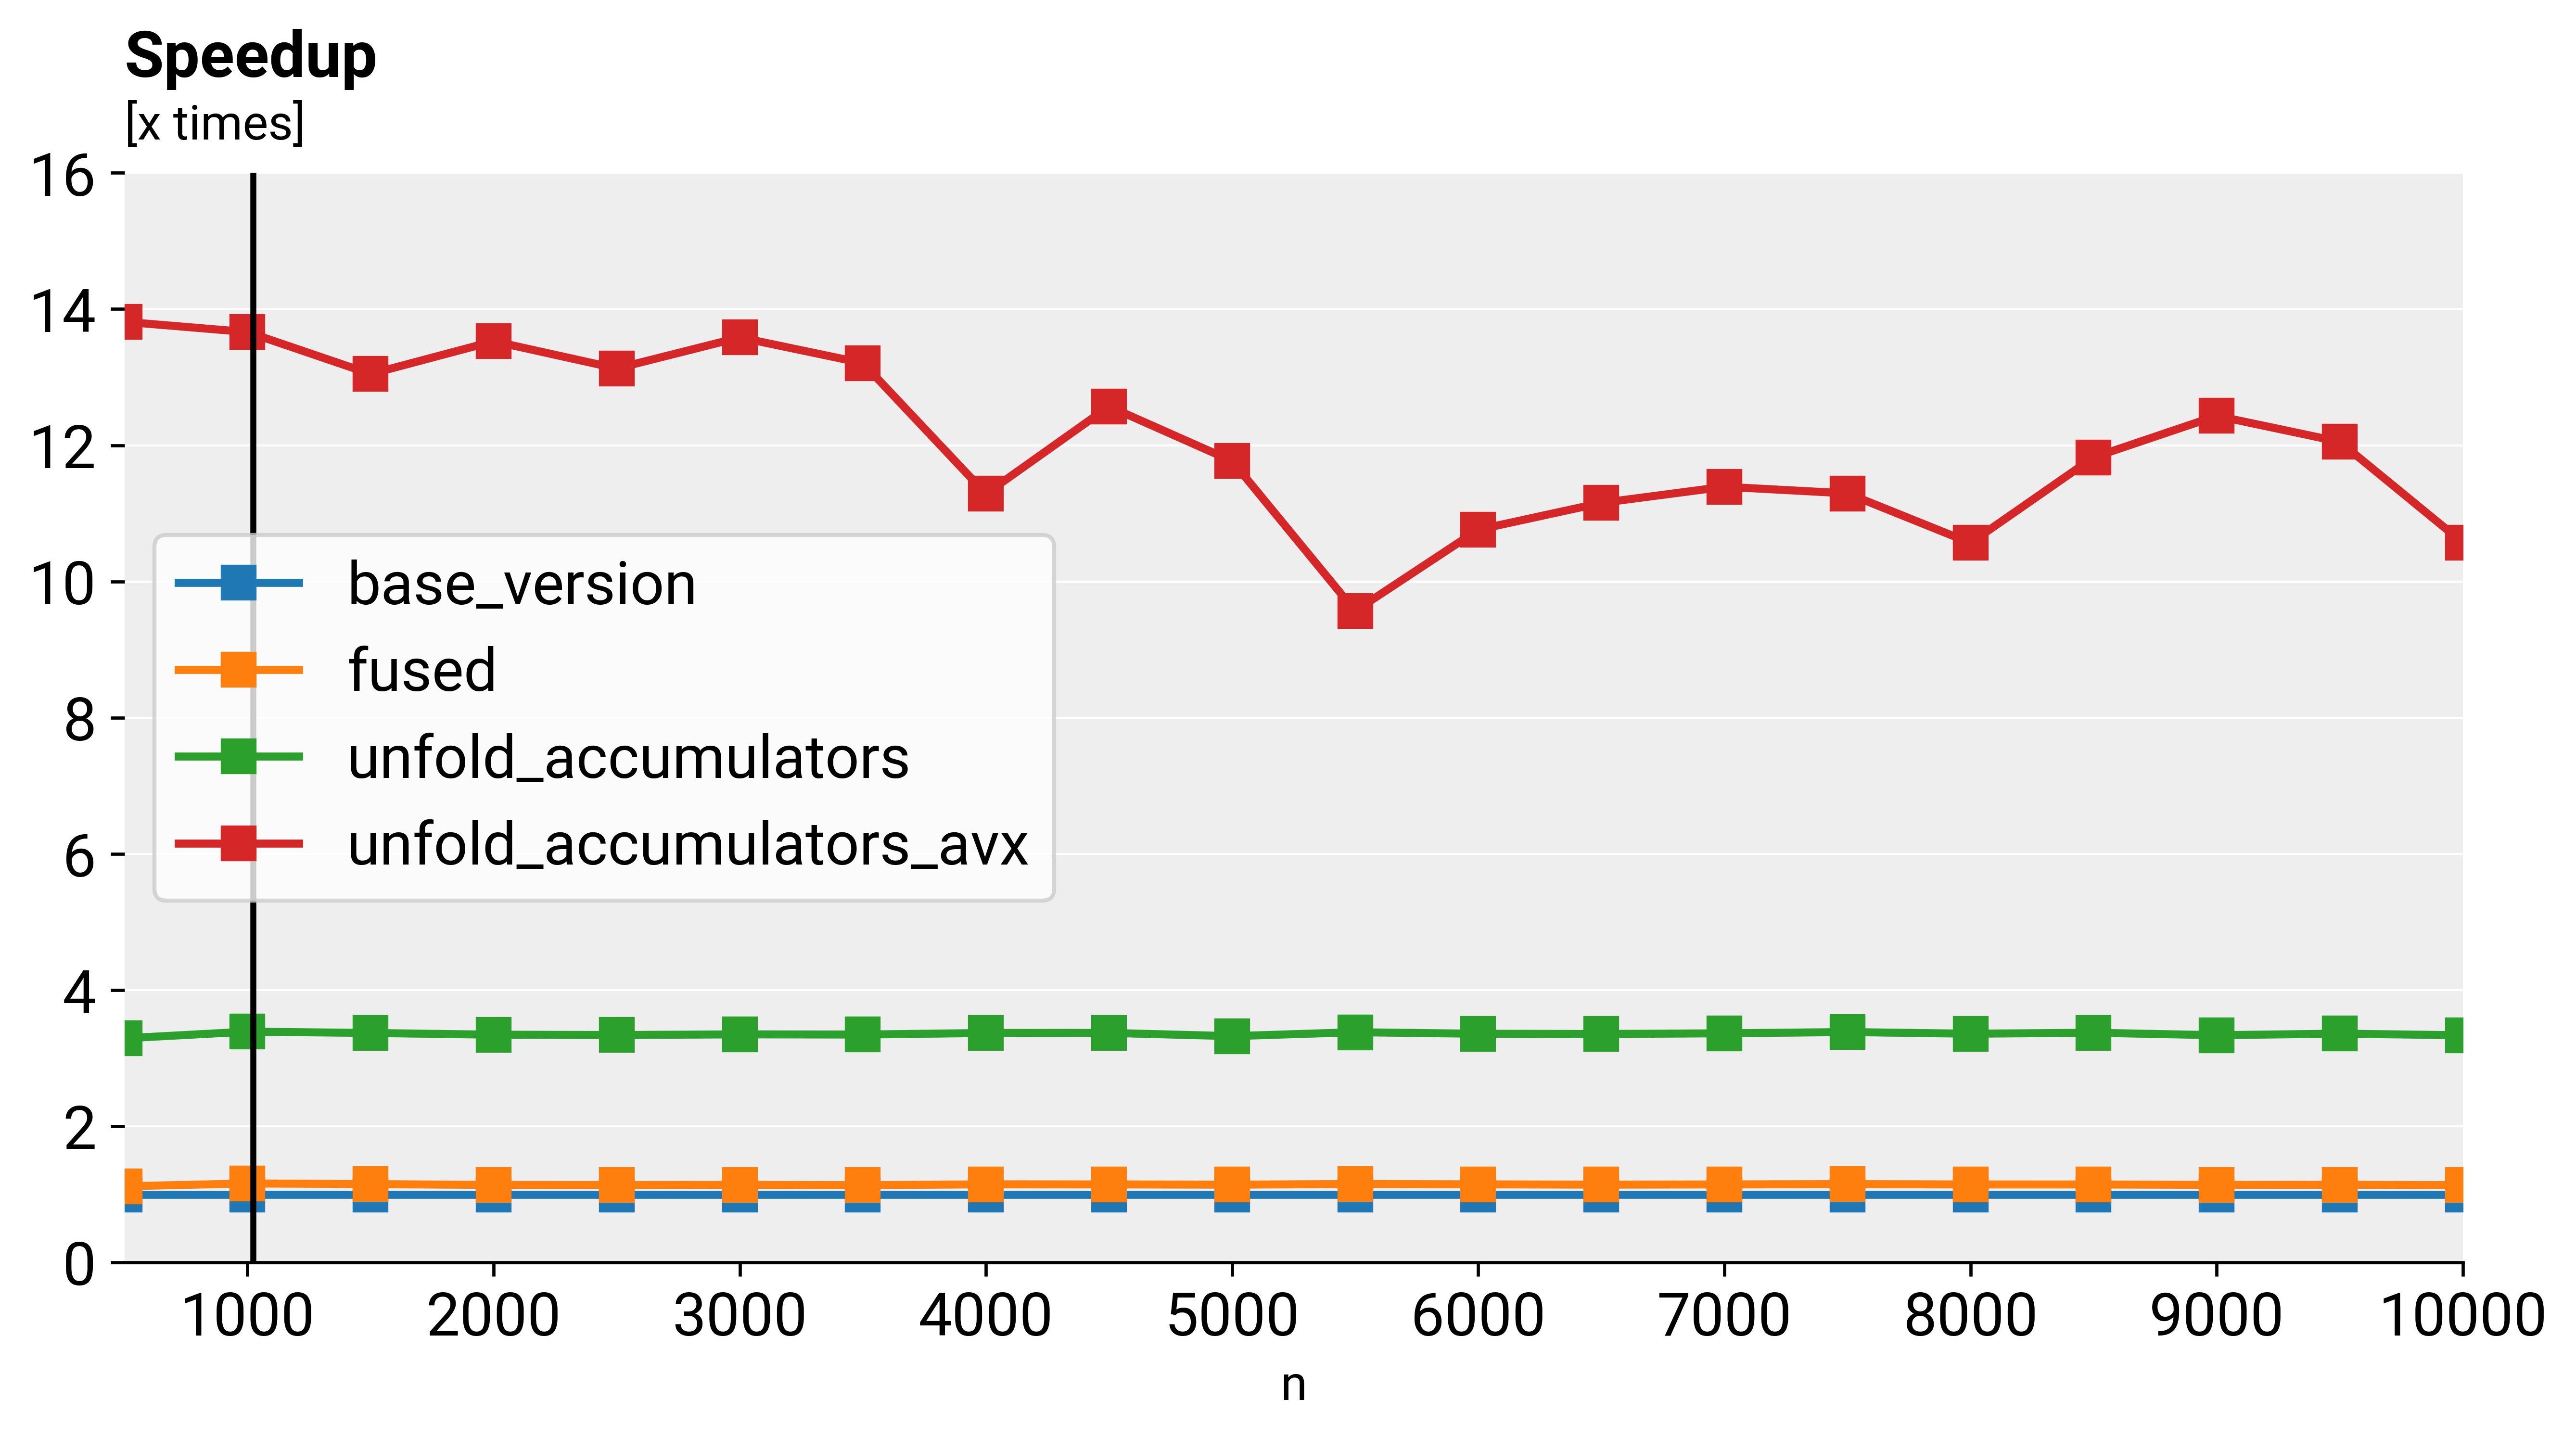

In [9]:
speedup = perf / perf[0]
ax = plot(N, speedup, labels=func_names, ylim=16, title="Speedup", ylabel="x times")
ax.set_xticks(np.arange(1000, 10000+1, 1000))
ax.set_xticklabels(np.arange(1000, 10000+1, 1000))
ax.axvline(N_cache3, c="k")
plt.show()